In [1]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [2]:
L = 1e-2
N_x = 200
N_p = 5000
h = L/N_x
tau = 2e-13

In [3]:
n0 = 1e17
n1 = n0*N_x/N_p
q = 1.60217e-19
m_e = 9.1093837e-31
m_i = 1.672e-27#*131
epsilon = 8.85e-12

In [4]:
eV = 11600

In [5]:
E1_factor = 1.60218e-19

In [6]:
E1 = 18.3*E1_factor
alpha = 0.62

In [7]:
T_e = eV*20
T_i = 600
k_b = 1.38e-23
v_t_e = math.sqrt(3*k_b*T_e/m_e)
vmin_e = -3*v_t_e
vmax_e = 3*v_t_e
v_t_i = math.sqrt(3*k_b*T_i/m_i)
vmin_i = -3*v_t_i
vmax_i = 3*v_t_i

In [8]:
r_d = math.sqrt(epsilon * k_b * T_e / (q * q * n0));

In [9]:
r_d

0.00010506222052218572

In [10]:
h

5e-05

In [11]:
ions = Particles(N_p, n1, q, m_i)
electrons = Particles(N_p, n1, -q, m_e)
nodes = Nodes(N_x)

In [12]:
left_wall = Wall(0, L/10, 0, h, "left")
right_wall = Wall(9*L/10, L, 0, h, "right")

In [13]:
set_homogeneous(electrons, left_wall.right*h, right_wall.left*h)

In [14]:
set_homogeneous(ions, left_wall.right*h, right_wall.left*h)

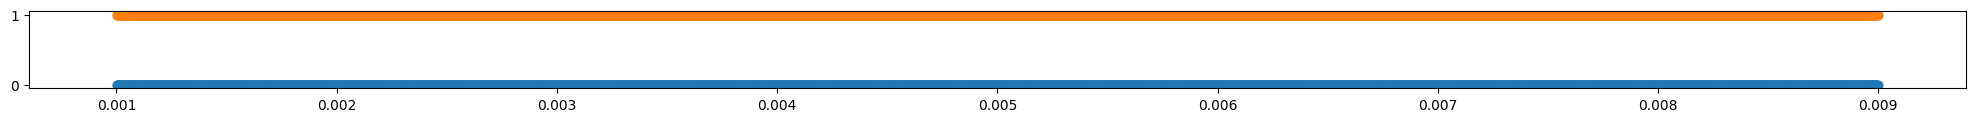

In [15]:
fig, ax = plt.subplots(1, 1)
ax.scatter(electrons.x, np.zeros(electrons.x.shape))
ax.scatter(ions.x, np.ones(ions.x.shape))
fig.set_size_inches((25, 1))


In [16]:
e_integral = get_integral(Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 100000)
i_integral = get_integral(Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 100000)

In [17]:
see_integral = get_integral(Maxwell(1*eV, k_b, m_e), vmin_e, vmax_e, 100000)

In [18]:
electrons.normalise(h, tau)
ions.normalise(h, tau)

In [19]:
set_distr(electrons, e_integral, h, tau)
set_distr(ions, i_integral, h, tau)

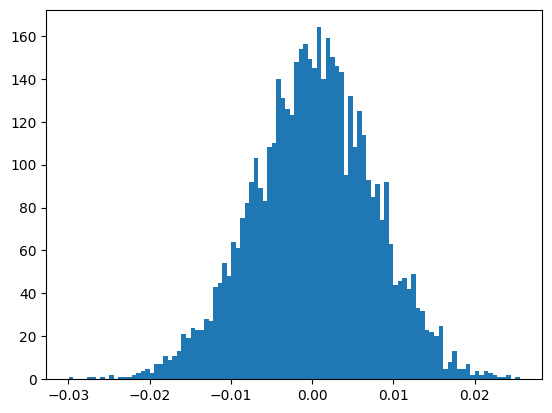

In [20]:
plt.hist(electrons.v, bins = 100)
%matplotlib inline

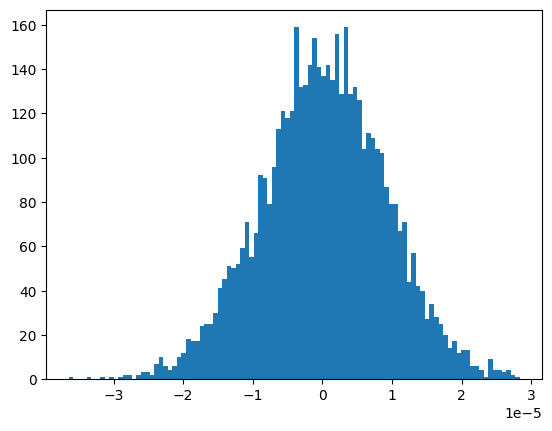

In [21]:
plt.hist(ions.v, bins = 100)
%matplotlib inline

In [22]:
get_rho(nodes, electrons)
get_rho(nodes, ions)

In [23]:
calc_fields(nodes, h, epsilon)

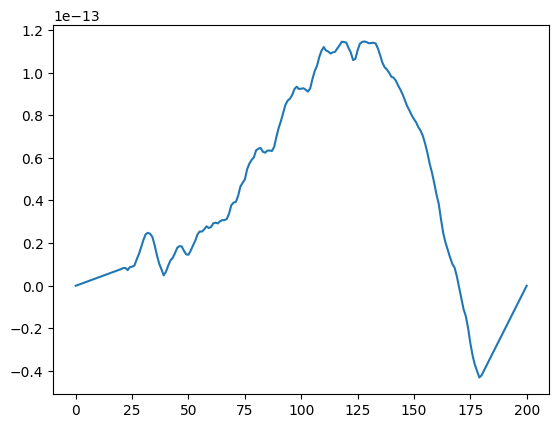

In [24]:
plt.plot(nodes.phi)

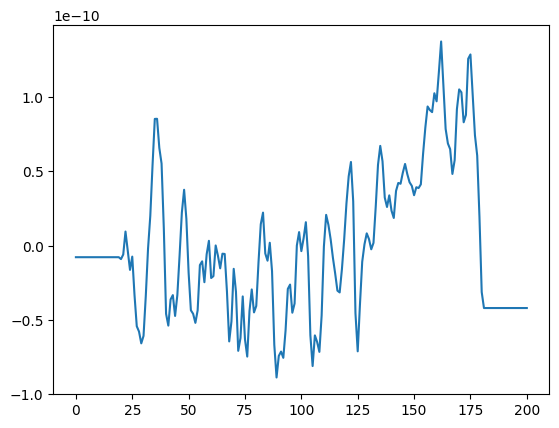

In [25]:
plt.plot(nodes.E)

In [26]:
accel(electrons, nodes, L, h, tau, zerostep=True)
accel(ions, nodes, L, h, tau, zerostep=True)

In [27]:
print(ions.v[ions.v>=1])

[]


In [28]:
print(electrons.v[electrons.v>=1])

[]


In [29]:
electron_distrs = []
ion_distrs = []

In [30]:
phi_over_time = []
E_over_time = []

In [31]:
n = 25000

In [32]:
walls = (left_wall, right_wall)

In [33]:
see_dict = {"E1": E1, "alpha": alpha, "h": h, "tau": tau, "see_integral": see_integral}

In [34]:
energy_dict = {"electric": [], "kinetic": [], "summ": [], "h": h, "tau": tau, "nodes": nodes}

In [35]:
maxwellise = True

In [36]:
n_range = (50, 150)

In [37]:
injection = {"n_range": n_range, "nodes": nodes, "h": h, "tau": tau,
             "i_integral": i_integral, "e_integral": e_integral, "electrons": electrons}

In [38]:
def check_boundaries(phase: str, particles_set):
    
    for particles in particles_set:
        r_mask = particles.x > right_wall.left
        l_mask = particles.x < left_wall.right
        if (np.sum(r_mask)+np.sum(l_mask)) > 0:
            print("\n")
            print("------------")
            print(phase, t)
            print(particles.q)
        if np.sum(r_mask) > 0:
            print(particles.x[r_mask]) 
        if np.sum(l_mask) > 0:
            print(particles.x[l_mask]) 



In [39]:
for t in tqdm(range(n)):
    try:
        move(electrons, nodes, consistency=True)
        move(ions, nodes, consistency=True)
    except Exception:
        print("number of iteration: ", t)
        break

    nodes.rho *= 0
    
    account_walls([electrons, ions], walls, SEE=see_dict, Energy=energy_dict, injection=injection)
    #check_boundaries("accounting_walls", (electrons, ions))
    
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    #check_boundaries("getting rho", (electrons, ions))
    for wall in walls:
        for particles in wall.particles_lst:
            get_rho(nodes, particles)
    
    calc_fields(nodes, h, epsilon)
    phi_over_time.append(nodes.phi.copy())
    E_over_time.append(nodes.E.copy())
    accel(electrons, nodes, L, h, tau)
    accel(ions, nodes,  L, h, tau)
    
    electrons.denormalise(h, tau)
    ions.denormalise(h, tau)
    electron_distrs.append(electrons.v.copy())
    ion_distrs.append(ions.v.copy())
    electrons.normalise(h, tau)
    ions.normalise(h, tau)
    if maxwellise:
        set_distr(electrons, e_integral, h, tau, n_range)
        set_distr(ions, i_integral, h, tau, n_range)
    

100%|██████████| 25000/25000 [11:41<00:00, 35.63it/s]


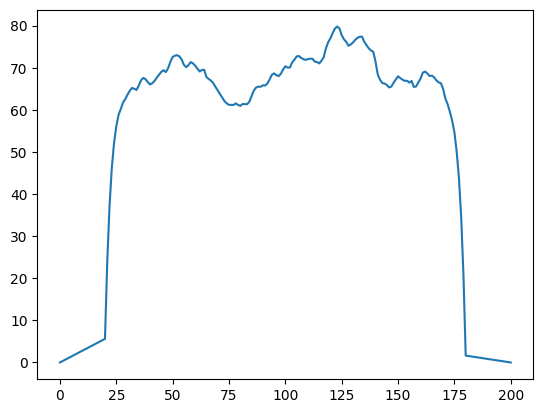

In [36]:
plt.plot(phi_over_time[-1])

In [37]:
electrons.n_macro

4764

In [38]:
ions.n_macro

5000

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


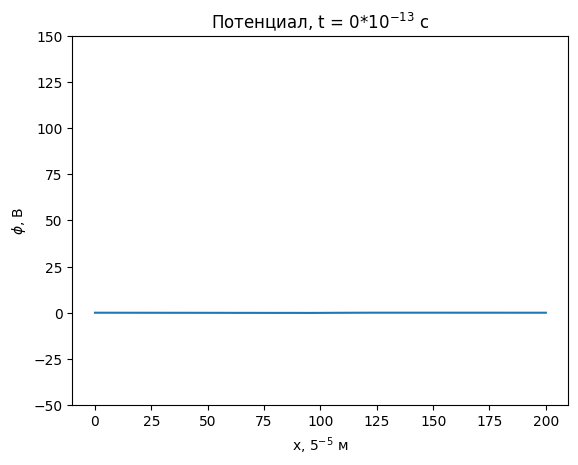

In [39]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(phi_over_time[i*50])
        ax.set_title("Потенциал, t = " + str(i*50)+ r"$*10^{-13}$ c")
        #ax.axvline(x=left_wall.right, color='k', linestyle='--', linewidth=1)
        #ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_ylim(-50, 150)
        ax.set_ylabel(r"$\phi$, В")
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/load_phi_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


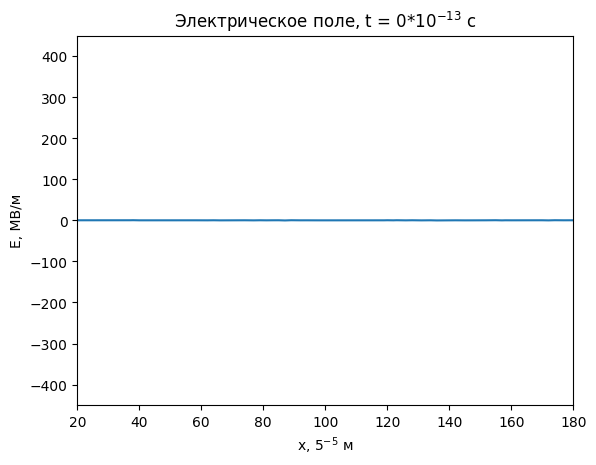

In [40]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(E_over_time[i*50]/1000)
        ax.set_title("Электрическое поле, t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_ylim(-450, 450)
        ax.set_ylabel(r"E, МВ/м")
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/load_E_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


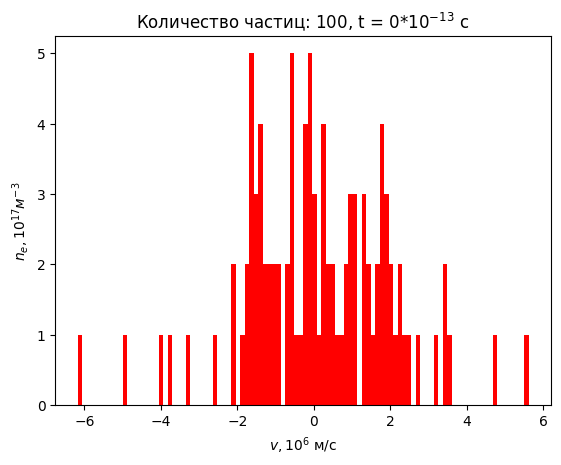

In [47]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(electron_distrs[i*50]0/1e6), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(electron_distrs[i*50]0/1e6), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(electron_distrs[i*50]0/1e6, 75) - np.percentile(electron_distrs[i*50]0/1e6, 25))/len(electron_distrs[i*50]0)**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)

        line = ax.hist(electron_distrs[0]0/1e6, bins=100, color="b")
        ax.hist(electron_distrs[i*50]0/1e6, bins=100, color = "r")
        ax.set_title("Количество частиц: " + str(len(electron_distrs[i*50]0)) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{6}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/load_electron_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


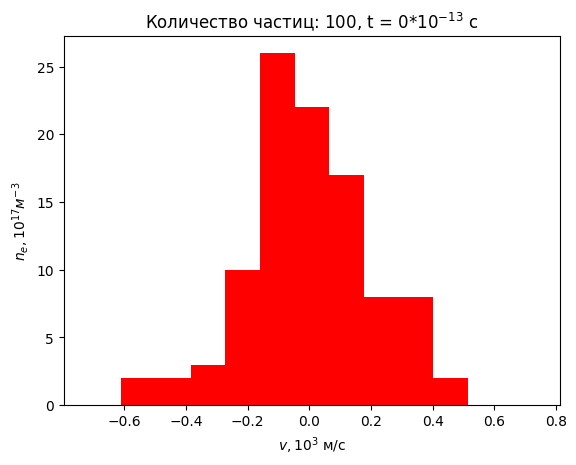

In [48]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(ion_distrs[i*50]0/1000), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(ion_distrs[i*50]0/1000), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(ion_distrs[i*50]0/1000, 75) - np.percentile(ion_distrs[i*50]0/1000, 25))/len(ion_distrs[i*50]0)**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)
        
        line = ax.hist(ion_distrs[0]0/1000, bins=bins, color="b")
        ax.hist(ion_distrs[i*50]0/1000, bins=bins, color="r")
        
        ax.set_title("Количество частиц: " + str(len(ion_distrs[i*50]0)) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{3}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/load_ion_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

In [44]:
import os
import imageio

gif_dir = 'results/'
paired_gif_dir = 'load_paired_gifs/'

SEE_gif_files = [filename for filename in os.listdir(gif_dir) if filename.startswith('SEE') and filename.endswith('.gif')]
reg_gif_files = [filename for filename in os.listdir(gif_dir) if not filename.startswith('SEE') and filename.endswith('.gif')]

for SEE_gif_file in SEE_gif_files:
    SEE_gif_path = os.path.join(gif_dir, SEE_gif_file)
    reg_gif_file = SEE_gif_file.replace('SEE', '').lstrip('_')
    reg_gif_path = os.path.join(gif_dir, reg_gif_file)
    if os.path.exists(reg_gif_path):
        SEE_gif = imageio.mimread(SEE_gif_path, memtest=False)
        reg_gif = imageio.mimread(reg_gif_path, memtest=False)
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        imageio.mimwrite(paired_gif_path, paired_gifs, format='gif', fps=30)


In [37]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Set directory paths
reg_gif_dir = 'path/to/regular/gifs'
SEE_gif_dir = 'path/to/SEE/gifs'
paired_gif_dir = 'path/to/paired/gifs'

# Loop through SEE gifs
for SEE_gif_file in os.listdir(SEE_gif_dir):
    if SEE_gif_file.startswith('SEE'):
        # Load regular gif
        reg_gif_file = SEE_gif_file.replace('SEE', '')
        reg_gif_path = os.path.join(reg_gif_dir, reg_gif_file)
        reg_gif = imageio.mimread(reg_gif_path)

        # Load SEE gif
        SEE_gif_path = os.path.join(SEE_gif_dir, SEE_gif_file)
        SEE_gif = imageio.mimread(SEE_gif_path)

        # Combine frames
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]

        # Add title to each frame
        for i, frame in enumerate(paired_gifs):
            fig, ax = plt.subplots()
            ax.imshow(frame, cmap='gray')
            if i == 0:
                ax.set_title('Regular GIF                          SEE GIF')
            plt.axis('off')

            # Save frame
            paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
            imageio.imwrite(paired_gif_path, frame)

        # Combine frames into GIF
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        with imageio.get_writer(paired_gif_path, mode='I', fps=30) as writer:
            for frame in paired_gifs:
                writer.append_data(frame)


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'path/to/SEE/gifs'

In [39]:
ions_over_time = np.array([len(x) for x in ion_distrs])

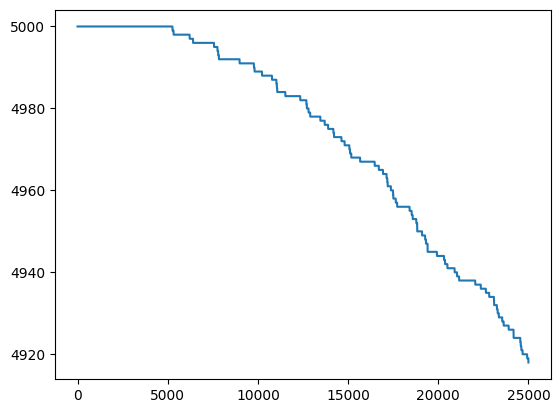

In [40]:
plt.plot(ions_over_time)

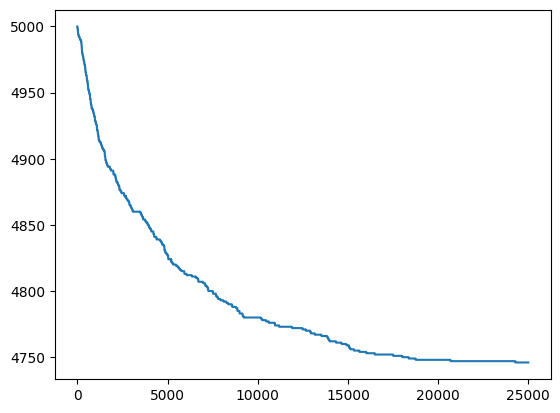

In [41]:
electrons_over_time = np.array([len(x) for x in electron_distrs])
plt.plot(electrons_over_time)


(array([2.50911614e-07, 4.18186024e-07, 1.67274409e-07, 3.34548819e-07,
        3.34548819e-07, 4.18186024e-07, 5.01823228e-07, 2.50911614e-07,
        2.50911614e-07, 4.18186024e-07, 6.69097638e-07, 5.85460433e-07,
        3.34548819e-07, 8.36372047e-07, 5.01823228e-07, 4.18186024e-07,
        9.20009252e-07, 8.36372047e-07, 9.20009252e-07, 1.42183248e-06,
        1.00364646e-06, 2.09093012e-06, 1.14582970e-05, 6.73279498e-05,
        1.47786941e-04, 1.19099380e-04, 3.40403423e-05, 5.01823228e-06,
        1.58910689e-06, 7.52734843e-07, 1.33819528e-06, 1.17092087e-06,
        6.69097638e-07, 5.01823228e-07, 7.52734843e-07, 4.18186024e-07,
        5.85460433e-07, 5.01823228e-07, 4.18186024e-07, 5.01823228e-07,
        4.18186024e-07, 4.18186024e-07, 4.18186024e-07, 5.01823228e-07,
        5.01823228e-07, 1.67274409e-07, 3.34548819e-07, 4.18186024e-07,
        8.36372047e-08, 2.50911614e-07]),
 array([-60222.11855083, -57790.96737177, -55359.81619272, -52928.66501366,
        -50497.513

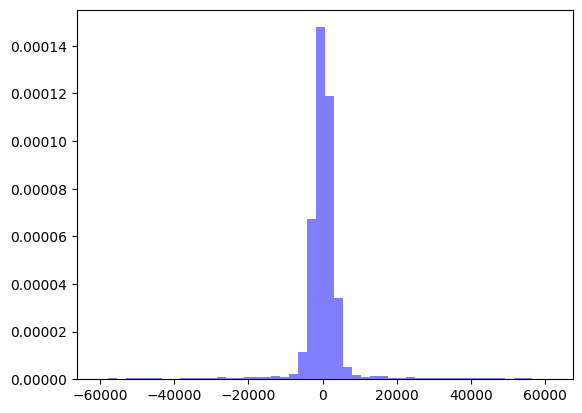

In [44]:
plt.hist(ion_distrs[-1], bins=50, density=True, facecolor='blue', alpha=0.5)

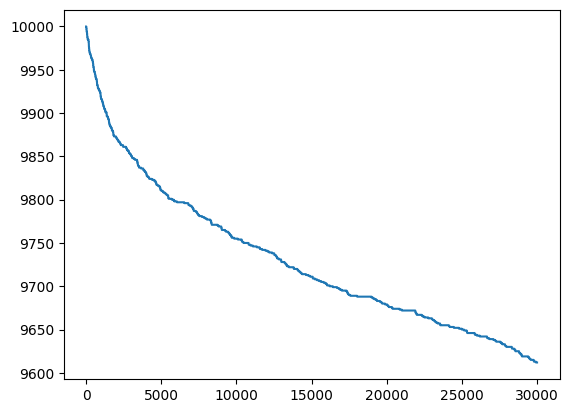

In [39]:
plt.plot(electrons_over_time+ions_over_time)
